<a href="https://colab.research.google.com/github/r0cketr1kky/COVID-19_X-Ray/blob/master/smooth_score1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [0]:
import os
import copy
import numpy as np
from PIL import Image, ImageFilter
import matplotlib.cm as mpl_color_map

import torch
from torch.autograd import Variable
from torchvision import models


def convert_to_grayscale(im_as_arr):
    """
        Converts 3d image to grayscale
    Args:
        im_as_arr (numpy arr): RGB image with shape (D,W,H)
    returns:
        grayscale_im (numpy_arr): Grayscale image with shape (1,W,D)
    """
    grayscale_im = np.sum(np.abs(im_as_arr), axis=0)
    im_max = np.percentile(grayscale_im, 99)
    im_min = np.min(grayscale_im)
    grayscale_im = (np.clip((grayscale_im - im_min) / (im_max - im_min), 0, 1))
    grayscale_im = np.expand_dims(grayscale_im, axis=0)
    return grayscale_im


def save_gradient_images(gradient, file_name):
    """
        Exports the original gradient image
    Args:
        gradient (np arr): Numpy array of the gradient with shape (3, 224, 224)
        file_name (str): File name to be exported
    """
    if not os.path.exists('../results'):
        os.makedirs('../results')
    # Normalize
    gradient = gradient - gradient.min()
    gradient /= gradient.max()
    # Save image
    path_to_file = os.path.join('../results', file_name + '.jpg')
    save_image(gradient, path_to_file)


def save_class_activation_images(org_img, activation_map):
    """
        Saves cam activation map and activation map on the original image
    Args:
        org_img (PIL img): Original image
        activation_map (numpy arr): Activation map (grayscale) 0-255
    """
    if not os.path.exists('../results'):
        os.makedirs('../results')
    # Grayscale activation map
    heatmap, heatmap_on_image = apply_colormap_on_image(org_img, activation_map, 'hsv')
    # Save colored heatmap
    path_to_file = os.path.join('../results', '/_Cam_Heatmap.png')
    save_image(heatmap, path_to_file)
    # Save heatmap on iamge
    path_to_file = os.path.join('../results', '/_Cam_On_Image.png')
    save_image(heatmap_on_image, path_to_file)
    # SAve grayscale heatmap
    path_to_file = os.path.join('../results', '/_Cam_Grayscale.png')
    save_image(activation_map, path_to_file)


def apply_colormap_on_image(org_im, activation, colormap_name):
    """
        Apply heatmap on image
    Args:
        org_img (PIL img): Original image
        activation_map (numpy arr): Activation map (grayscale) 0-255
        colormap_name (str): Name of the colormap
    """
    # Get colormap
    color_map = mpl_color_map.get_cmap(colormap_name)
    no_trans_heatmap = color_map(activation)
    # Change alpha channel in colormap to make sure original image is displayed
    heatmap = copy.copy(no_trans_heatmap)
    heatmap[:, :, 3] = 0.4
    heatmap = Image.fromarray((heatmap*255).astype(np.uint8))
    no_trans_heatmap = Image.fromarray((no_trans_heatmap*255).astype(np.uint8))

    # Apply heatmap on iamge
    heatmap_on_image = Image.new("RGBA", org_im.size)
    heatmap_on_image = Image.alpha_composite(heatmap_on_image, org_im.convert('RGBA'))
    heatmap_on_image = Image.alpha_composite(heatmap_on_image, heatmap)
    return no_trans_heatmap, heatmap_on_image


def format_np_output(np_arr):
    """
        This is a (kind of) bandaid fix to streamline saving procedure.
        It converts all the outputs to the same format which is 3xWxH
        with using sucecssive if clauses.
    Args:
        im_as_arr (Numpy array): Matrix of shape 1xWxH or WxH or 3xWxH
    """
    # Phase/Case 1: The np arr only has 2 dimensions
    # Result: Add a dimension at the beginning
    if len(np_arr.shape) == 2:
        np_arr = np.expand_dims(np_arr, axis=0)
    # Phase/Case 2: Np arr has only 1 channel (assuming first dim is channel)
    # Result: Repeat first channel and convert 1xWxH to 3xWxH
    if np_arr.shape[0] == 1:
        np_arr = np.repeat(np_arr, 3, axis=0)
    # Phase/Case 3: Np arr is of shape 3xWxH
    # Result: Convert it to WxHx3 in order to make it saveable by PIL
    if np_arr.shape[0] == 3:
        np_arr = np_arr.transpose(1, 2, 0)
    # Phase/Case 4: NP arr is normalized between 0-1
    # Result: Multiply with 255 and change type to make it saveable by PIL
    if np.max(np_arr) <= 1:
        np_arr = (np_arr*255).astype(np.uint8)
    return np_arr


def save_image(im, path):
    """
        Saves a numpy matrix or PIL image as an image
    Args:
        im_as_arr (Numpy array): Matrix of shape DxWxH
        path (str): Path to the image
    """
    if isinstance(im, (np.ndarray, np.generic)):
        im = format_np_output(im)
        im = Image.fromarray(im)
    im.save(path)


def preprocess_image(pil_im, resize_im=True):
    """
        Processes image for CNNs
    Args:
        PIL_img (PIL_img): PIL Image or numpy array to process
        resize_im (bool): Resize to 224 or not
    returns:
        im_as_var (torch variable): Variable that contains processed float tensor
    """
    # mean and std list for channels (Imagenet)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    #ensure or transform incoming image to PIL image
    if type(pil_im) != Image.Image:
        try:
            pil_im = Image.fromarray(pil_im)
        except Exception as e:
            print("could not transform PIL_img to a PIL Image object. Please check input.")

    # Resize image
    if resize_im:
        pil_im = pil_im.resize((224, 224), Image.ANTIALIAS)

    im_as_arr = np.float32(pil_im)
    im_as_arr = im_as_arr.transpose(2, 0, 1)  # Convert array to D,W,H
    # Normalize the channels
    for channel, _ in enumerate(im_as_arr):
        im_as_arr[channel] /= 255
        im_as_arr[channel] -= mean[channel]
        im_as_arr[channel] /= std[channel]
    # Convert to float tensor
    im_as_ten = torch.from_numpy(im_as_arr).float()
    # Add one more channel to the beginning. Tensor shape = 1,3,224,224
    im_as_ten.unsqueeze_(0)
    # Convert to Pytorch variable
    im_as_var = Variable(im_as_ten, requires_grad=True)
    return im_as_var


def recreate_image(im_as_var):
    """
        Recreates images from a torch variable, sort of reverse preprocessing
    Args:
        im_as_var (torch variable): Image to recreate
    returns:
        recreated_im (numpy arr): Recreated image in array
    """
    reverse_mean = [-0.485, -0.456, -0.406]
    reverse_std = [1/0.229, 1/0.224, 1/0.225]
    recreated_im = copy.copy(im_as_var.data.numpy()[0])
    for c in range(3):
        recreated_im[c] /= reverse_std[c]
        recreated_im[c] -= reverse_mean[c]
    recreated_im[recreated_im > 1] = 1
    recreated_im[recreated_im < 0] = 0
    recreated_im = np.round(recreated_im * 255)

    recreated_im = np.uint8(recreated_im).transpose(1, 2, 0)
    return recreated_im


def get_positive_negative_saliency(gradient):
    """
        Generates positive and negative saliency maps based on the gradient
    Args:
        gradient (numpy arr): Gradient of the operation to visualize
    returns:
        pos_saliency ( )
    """
    pos_saliency = (np.maximum(0, gradient) / gradient.max())
    neg_saliency = (np.maximum(0, -gradient) / -gradient.min())
    return pos_saliency, neg_saliency


def get_example_params(example_index):
    """
        Gets used variables for almost all visualizations, like the image, model etc.
    Args:
        example_index (int): Image id to use from examples
    returns:
        original_image (numpy arr): Original image read from the file
        prep_img (numpy_arr): Processed image
        target_class (int): Target class for the image
        pretrained_model(Pytorch model): Model to use for the operations
    """
    # Pick one of the examples
    
    # Read image
    original_image = Image.open(img_path).convert('RGB')
    # Process image
    prep_img = preprocess_image(original_image)
    # Define model
    #pretrained_model = model
    return (original_image,
            prep_img,
            target_class)
    
import torch
import torch.nn as nn


class BaseProp(object):
    """
        Base class for backpropagation.
    """

    def __init__(self, model):
        """Init
        # Arguments:
            model: torchvision.models. A pretrained model.
            handle: list. Handle list that register a hook function.
            relu_outputs: list. Forward output after relu.
        """
        self.model = model
        self.handle = []
        self.relu_outputs = []

    def _register_conv_hook(self):

        """
            Register hook function to save gradient w.r.t input image.
        """

        def _record_gradients(module, grad_in, grad_out):
                self.gradients = grad_in[0]

        for _, module in self.model.named_modules():
            if isinstance(module, nn.modules.conv.Conv2d) and module.in_channels == 3:
                backward_handle = module.register_backward_hook(_record_gradients)
                self.handle.append(backward_handle)

    def _register_relu_hooks(self):

        """
            Register hook function to save forward and backward relu result.
        """

        # Save forward propagation output of the ReLU layer
        def _record_output(module, input_, output):
            self.relu_outputs.append(output)

        def _clip_gradients(module, grad_in, grad_out):
            # keep positive forward propagation output
            relu_output = self.relu_outputs.pop()
            relu_output[relu_output > 0] = 1

            # keep positive backward propagation gradient
            positive_grad_out = torch.clamp(grad_out[0], min=0.0)

            # generate modified guided gradient
            modified_grad_out = positive_grad_out * relu_output

            return (modified_grad_out, )

        for _, module in self.model.named_modules():
            if isinstance(module, nn.ReLU):
                forward_handle = module.register_forward_hook(_record_output)
                backward_handle = module.register_backward_hook(_clip_gradients)
                self.handle.append(forward_handle)
                self.handle.append(backward_handle)

class VanillaBackprop():
    """
        Produces gradients generated with vanilla back propagation from the image
    """
    def __init__(self, model):
        self.model = model
        self.gradients = None
        # Put model in evaluation mode
        self.model.eval()
        # Hook the first layer to get the gradient
        self.hook_layers()

    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            self.gradients = grad_in[0]

        # Register hook to the first layer
        first_layer = list(self.model.features._modules.items())[0][1]
        first_layer.register_backward_hook(hook_function)

    def generate_gradients(self, input_image, target_class):
        # Forward
        model_output = self.model(input_image)
        # Zero grads
        self.model.zero_grad()
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        # Backward pass
        model_output.backward(gradient=one_hot_output)
        # Convert Pytorch variable to numpy array
        # [0] to get rid of the first channel (1,3,224,224)
        gradients_as_arr = self.gradients.data.numpy()[0]
        return gradients_as_arr

class Backprop(BaseProp):

    """ Generates vanilla or guided backprop gradients of a target class output w.r.t. an input image.
        # Arguments:
            model: torchvision.models. A pretrained model.
            guided: bool. If True, perform guided backpropagation. Defaults to False.
        # Return:
            Backprop Class.
    """

    def __init__(self, model, guided=False):
        super().__init__(model)
        self.model.eval()
        self.guided = guided
        self.gradients = None
        self._register_conv_hook()

    def calculate_gradients(self,
                            input_,
                            target_class=None,
                            take_max=False,
                            use_gpu=False):

        """ Calculate gradient.
            # Arguments
                input_: torch.Tensor. Preprocessed image with shape (1, C, H, W).
                target_class: int. Index of target class. Default to None and use the prediction result as target class.
                take_max: bool. Take the maximum across colour channels. Defaults to False.
                use_gpu. bool. Use GPU or not. Defaults to False.
            # Return:
                Gradient (torch.Tensor) with shape (C, H, W). If take max is True, with shape (1, H, W).
        """

        if self.guided:
            self._register_relu_hooks()

        # Create a empty tensor to save gradients
        self.gradients = torch.zeros(input_.shape)

        output = self.model(input_)

        self.model.zero_grad()

        if output.shape == torch.Size([1]):
            target = None
        else:
            pred_class = output.argmax().item()

            # Create a Tensor with zero elements, set the element at pred class index to be 1
            target = torch.zeros(output.shape)

            # If target class is None, calculate gradient of predicted class.
            if target_class is None:
                target[0][pred_class] = 1
            else:
                target[0][target_class] = 1

            
        # Calculate gradients w.r.t. input image
        output.backward(gradient=target)

        gradients = self.gradients.detach().cpu()[0]

        if take_max:
            gradients = gradients.max(dim=0, keepdim=True)[0]

        for module in self.handle:
            module.remove()
        gradients = gradients.numpy()
        return gradients

import numpy as np

from torch.autograd import Variable
import torch

from PIL import Image

# from guided_backprop import GuidedBackprop  # To use with guided backprop


def generate_smooth_grad(Backprop, prep_img, target_class, param_n, param_sigma_multiplier):
    """
        Generates smooth gradients of given Backprop type. You can use this with both vanilla
        and guided backprop
    Args:
        Backprop (class): Backprop type
        prep_img (torch Variable): preprocessed image
        target_class (int): target class of imagenet
        param_n (int): Amount of images used to smooth gradient
        param_sigma_multiplier (int): Sigma multiplier when calculating std of noise
    """
    # Generate an empty image/matrix
    smooth_grad = np.zeros(prep_img.size()[1:])

    mean = 0
    sigma = param_sigma_multiplier / (torch.max(prep_img) - torch.min(prep_img)).item()
    
    for x in range(param_n):
        # Generate noise
        noise = Variable(prep_img.data.new(prep_img.size()).normal_(mean, sigma**2))
        # Add noise to the image
        noisy_img = prep_img + noise
        # Calculate gradients
        vanilla_grads = Backprop.calculate_gradients(noisy_img, target_class)
        # Add gradients to smooth_grad
        smooth_grad = smooth_grad + vanilla_grads
    # Average it out
    smooth_grad = smooth_grad / param_n
    return smooth_grad

def process_image(image_path):
    """Process an image path into a PyTorch tensor"""

    image = Image.open(image_path)
    # Resize
    img = image.resize((256, 256))

    # Center crop
    width = 256
    height = 256
    new_width = 224
    new_height = 224

    left = (width - new_width) / 2
    top = (height - new_height) / 2
    right = (width + new_width) / 2
    bottom = (height + new_height) / 2
    img = img.crop((left, top, right, bottom))

    # Convert to numpy, transpose color dimension and normalize
    img = np.array(img).transpose((2, 0, 1)) / 256

    # Standardization
    means = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
    stds = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))

    img = img - means
    img = img / stds

    img_tensor = torch.Tensor(img)

    return img_tensor

In [0]:
#!/usr/bin/env python
"""flashtorch.utils

This module provides utility functions for image handling and tensor
transformation.

"""
from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.transforms.functional as F
import torchvision.models

def load_image(image_path):
    """Loads image as a PIL RGB image.

        Args:
            - **image_path (str) - **: A path to the image

        Returns:
            An instance of PIL.Image.Image in RGB

    """

    return Image.open(image_path).convert('RGB')


def apply_transforms(image, size=224):
    """Transforms a PIL image to torch.Tensor.

    Applies a series of tranformations on PIL image including a conversion
    to a tensor. The returned tensor has a shape of :math:`(N, C, H, W)` and
    is ready to be used as an input to neural networks.

    First the image is resized to 256, then cropped to 224. The `means` and
    `stds` for normalisation are taken from numbers used in ImageNet, as
    currently developing the package for visualizing pre-trained models.

    The plan is to to expand this to handle custom size/mean/std.

    Args:
        image (PIL.Image.Image or numpy array)
        size (int, optional, default=224): Desired size (width/height) of the
            output tensor

    Shape:
        Input: :math:`(C, H, W)` for numpy array
        Output: :math:`(N, C, H, W)`

    Returns:
        torch.Tensor (torch.float32): Transformed image tensor

    Note:
        Symbols used to describe dimensions:
            - N: number of images in a batch
            - C: number of channels
            - H: height of the image
            - W: width of the image

    """

    if not isinstance(image, Image.Image):
        image = F.to_pil_image(image)

    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]

    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.CenterCrop(size),
        transforms.ToTensor(),
        transforms.Normalize(means, stds)
    ])

    tensor = transform(image).unsqueeze(0)

    tensor.requires_grad = True

    return tensor

def apply_transforms_v0(image, size=224):
    """Transforms a PIL image to torch.Tensor.

    Applies a series of tranformations on PIL image including a conversion
    to a tensor. The returned tensor has a shape of :math:`(N, C, H, W)` and
    is ready to be used as an input to neural networks.

    First the image is resized to 256, then cropped to 224. The `means` and
    `stds` for normalisation are taken from numbers used in ImageNet, as
    currently developing the package for visualizing pre-trained models.

    The plan is to to expand this to handle custom size/mean/std.

    Args:
        image (PIL.Image.Image or numpy array)
        size (int, optional, default=224): Desired size (width/height) of the
            output tensor

    Shape:
        Input: :math:`(C, H, W)` for numpy array
        Output: :math:`(N, C, H, W)`

    Returns:
        torch.Tensor (torch.float32): Transformed image tensor

    Note:
        Symbols used to describe dimensions:
            - N: number of images in a batch
            - C: number of channels
            - H: height of the image
            - W: width of the image

    """

    if not isinstance(image, Image.Image):
        image = F.to_pil_image(image)

    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]

    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.CenterCrop(size),
        transforms.ToTensor()
    ])

    tensor = transform(image).unsqueeze(0)

    tensor.requires_grad = True

    return tensor


def denormalize(tensor):
    """Reverses the normalisation on a tensor.

    Performs a reverse operation on a tensor, so the pixel value range is
    between 0 and 1. Useful for when plotting a tensor into an image.

    Normalisation: (image - mean) / std
    Denormalisation: image * std + mean

    Args:
        tensor (torch.Tensor, dtype=torch.float32): Normalized image tensor

    Shape:
        Input: :math:`(N, C, H, W)`
        Output: :math:`(N, C, H, W)` (same shape as input)

    Return:
        torch.Tensor (torch.float32): Demornalised image tensor with pixel
            values between [0, 1]

    Note:
        Symbols used to describe dimensions:
            - N: number of images in a batch
            - C: number of channels
            - H: height of the image
            - W: width of the image

    """

    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]

    denormalized = tensor.clone()

    for channel, mean, std in zip(denormalized[0], means, stds):
        channel.mul_(std).add_(mean)

    return denormalized


def standardize_and_clip(tensor, min_value=0.0, max_value=1.0):
    """Standardizes and clips input tensor.

    Standardize the input tensor (mean = 0.0, std = 1.0), ensures std is 0.1
    and clips it to values between min/max (default: 0.0/1.0).

    Args:
        tensor (torch.Tensor):
        min_value (float, optional, default=0.0)
        max_value (float, optional, default=1.0)

    Shape:
        Input: :math:`(C, H, W)`
        Output: Same as the input

    Return:
        torch.Tensor (torch.float32): Normalised tensor with values between
            [min_value, max_value]

    """

    tensor = tensor.detach().cpu()

    mean = tensor.mean()
    std = tensor.std()
    if std == 0:
        std += 1e-7

    standardized = tensor.sub(mean).div(std).mul(0.1)
    clipped = standardized.add(0.5).clamp(min_value, max_value)

    return clipped


def format_for_plotting(tensor):
    """Formats the shape of tensor for plotting.

    Tensors typically have a shape of :math:`(N, C, H, W)` or :math:`(C, H, W)`
    which is not suitable for plotting as images. This function formats an
    input tensor :math:`(H, W, C)` for RGB and :math:`(H, W)` for mono-channel
    data.

    Args:
        tensor (torch.Tensor, torch.float32): Image tensor

    Shape:
        Input: :math:`(N, C, H, W)` or :math:`(C, H, W)`
        Output: :math:`(H, W, C)` or :math:`(H, W)`, respectively

    Return:
        torch.Tensor (torch.float32): Formatted image tensor (detached)

    Note:
        Symbols used to describe dimensions:
            - N: number of images in a batch
            - C: number of channels
            - H: height of the image
            - W: width of the image

    """

    has_batch_dimension = len(tensor.shape) == 4
    formatted = tensor.clone()

    if has_batch_dimension:
        formatted = tensor.squeeze(0)

    if formatted.shape[0] == 1:
        return formatted.squeeze(0).detach()
    else:
        return formatted.permute(1, 2, 0).detach()


def visualize(input_, gradients, save_path=None, cmap='viridis', alpha=0.7):

    """ Method to plot the explanation.

        # Arguments
            input_: Tensor. Original image.
            gradients: Tensor. Saliency map result.
            save_path: String. Defaults to None.
            cmap: Defaults to be 'viridis'.
            alpha: Defaults to be 0.7.

    """

    input_ = format_for_plotting(denormalize(input_))
    gradients = format_for_plotting(standardize_and_clip(gradients))

    subplots = [
        ('Input image', [(input_, None, None)]),
        ('Saliency map across RGB channels', [(gradients, None, None)]),
        ('Overlay', [(input_, None, None), (gradients, cmap, alpha)])
    ]

    num_subplots = len(subplots)

    fig = plt.figure(figsize=(16, 3))

    for i, (title, images) in enumerate(subplots):
        ax = fig.add_subplot(1, num_subplots, i + 1)
        ax.set_axis_off()

        for image, cmap, alpha in images:
            ax.imshow(image, cmap=cmap, alpha=alpha)

        ax.set_title(title)
    if save_path is not None:
        plt.savefig(save_path)


def basic_visualize(input_, gradients, save_path=None, weight=None, cmap='viridis', alpha=0.7):

    """ Method to plot the explanation.

        # Arguments
            input_: Tensor. Original image.
            gradients: Tensor. Saliency map result.
            save_path: String. Defaults to None.
            cmap: Defaults to be 'viridis'.
            alpha: Defaults to be 0.7.

    """
    input_ = format_for_plotting(denormalize(input_))
    gradients = format_for_plotting(standardize_and_clip(gradients))

    subplots = [
        ('Saliency map across RGB channels', [(gradients, None, None)]),
        ('Overlay', [(input_, None, None), (gradients, cmap, alpha)])
    ]

    num_subplots = len(subplots)

    fig = plt.figure(figsize=(4, 4))
    count=0
    for i, (title, images) in enumerate(subplots):
        ax = fig.add_subplot(1, num_subplots, i + 1)
        ax.set_axis_off()

        for image, cmap, alpha in images:
            print('hello {}'.format(count))
            count+=1
            ax.imshow(image, cmap=cmap, alpha=alpha)

    if save_path is not None:
        plt.savefig(save_path)

    return images


def find_resnet_layer(arch, target_layer_name):
    """Find resnet layer to calculate GradCAM and GradCAM++

    Args:
        arch: default torchvision densenet models
        target_layer_name (str): the name of layer with its hierarchical information. please refer to usages below.
            target_layer_name = 'conv1'
            target_layer_name = 'layer1'
            target_layer_name = 'layer1_basicblock0'
            target_layer_name = 'layer1_basicblock0_relu'
            target_layer_name = 'layer1_bottleneck0'
            target_layer_name = 'layer1_bottleneck0_conv1'
            target_layer_name = 'layer1_bottleneck0_downsample'
            target_layer_name = 'layer1_bottleneck0_downsample_0'
            target_layer_name = 'avgpool'
            target_layer_name = 'fc'

    Return:
        target_layer: found layer. this layer will be hooked to get forward/backward pass information.
    """
    if target_layer_name is None:
        target_layer_name = 'layer4'

    if 'layer' in target_layer_name:
        hierarchy = target_layer_name.split('_')
        layer_num = int(hierarchy[0].lstrip('layer'))
        if layer_num == 1:
            target_layer = arch.layer1
        elif layer_num == 2:
            target_layer = arch.layer2
        elif layer_num == 3:
            target_layer = arch.layer3
        elif layer_num == 4:
            target_layer = arch.layer4
        else:
            raise ValueError('unknown layer : {}'.format(target_layer_name))

        if len(hierarchy) >= 2:
            bottleneck_num = int(hierarchy[1].lower().lstrip('bottleneck').lstrip('basicblock'))
            target_layer = target_layer[bottleneck_num]

        if len(hierarchy) >= 3:
            target_layer = target_layer._modules[hierarchy[2]]

        if len(hierarchy) == 4:
            target_layer = target_layer._modules[hierarchy[3]]

    else:
        target_layer = arch._modules[target_layer_name]

    return target_layer


def find_densenet_layer(arch, target_layer_name):
    """Find densenet layer to calculate GradCAM and GradCAM++

    Args:
        arch: default torchvision densenet models
        target_layer_name (str): the name of layer with its hierarchical information. please refer to usages below.
            target_layer_name = 'features'
            target_layer_name = 'features_transition1'
            target_layer_name = 'features_transition1_norm'
            target_layer_name = 'features_denseblock2_denselayer12'
            target_layer_name = 'features_denseblock2_denselayer12_norm1'
            target_layer_name = 'features_denseblock2_denselayer12_norm1'
            target_layer_name = 'classifier'

    Return:
        target_layer: found layer. this layer will be hooked to get forward/backward pass information.
    """

    if target_layer_name is None:
        target_layer_name = 'features'

    hierarchy = target_layer_name.split('_')
    target_layer = arch._modules[hierarchy[0]]

    if len(hierarchy) >= 2:
        target_layer = target_layer._modules[hierarchy[1]]

    if len(hierarchy) >= 3:
        target_layer = target_layer._modules[hierarchy[2]]

    if len(hierarchy) == 4:
        target_layer = target_layer._modules[hierarchy[3]]

    return target_layer


def find_vgg_layer(arch, target_layer_name):
    """Find vgg layer to calculate GradCAM and GradCAM++

    Args:
        arch: default torchvision densenet models
        target_layer_name (str): the name of layer with its hierarchical information. please refer to usages below.
            target_layer_name = 'features'
            target_layer_name = 'features_42'
            target_layer_name = 'classifier'
            target_layer_name = 'classifier_0'

    Return:
        target_layer: found layer. this layer will be hooked to get forward/backward pass information.
    """
    if target_layer_name is None:
        target_layer_name = 'features'

    hierarchy = target_layer_name.split('_')

    if len(hierarchy) >= 1:
        target_layer = arch.features

    if len(hierarchy) == 2:
        target_layer = target_layer[int(hierarchy[1])]

    return target_layer


def find_alexnet_layer(arch, target_layer_name):
    """Find alexnet layer to calculate GradCAM and GradCAM++

    Args:
        arch: default torchvision densenet models
        target_layer_name (str): the name of layer with its hierarchical information. please refer to usages below.
            target_layer_name = 'features'
            target_layer_name = 'features_0'
            target_layer_name = 'classifier'
            target_layer_name = 'classifier_0'

    Return:
        target_layer: found layer. this layer will be hooked to get forward/backward pass information.
    """
    if target_layer_name is None:
        target_layer_name = 'features_29'

    hierarchy = target_layer_name.split('_')

    if len(hierarchy) >= 1:
        target_layer = arch.features

    if len(hierarchy) == 2:
        target_layer = target_layer[int(hierarchy[1])]

    return target_layer


def find_squeezenet_layer(arch, target_layer_name):
    """Find squeezenet layer to calculate GradCAM and GradCAM++

        Args:
            - **arch - **: default torchvision densenet models
            - **target_layer_name (str) - **: the name of layer with its hierarchical information. please refer to usages below.
                target_layer_name = 'features_12'
                target_layer_name = 'features_12_expand3x3'
                target_layer_name = 'features_12_expand3x3_activation'

        Return:
            target_layer: found layer. this layer will be hooked to get forward/backward pass information.
    """
    if target_layer_name is None:
        target_layer_name = 'features'

    hierarchy = target_layer_name.split('_')
    target_layer = arch._modules[hierarchy[0]]

    if len(hierarchy) >= 2:
        target_layer = target_layer._modules[hierarchy[1]]

    if len(hierarchy) == 3:
        target_layer = target_layer._modules[hierarchy[2]]

    elif len(hierarchy) == 4:
        target_layer = target_layer._modules[hierarchy[2] + '_' + hierarchy[3]]

    return target_layer


def find_googlenet_layer(arch, target_layer_name):
    """Find squeezenet layer to calculate GradCAM and GradCAM++

        Args:
            - **arch - **: default torchvision googlenet models
            - **target_layer_name (str) - **: the name of layer with its hierarchical information. please refer to usages below.
                target_layer_name = 'inception5b'

        Return:
            target_layer: found layer. this layer will be hooked to get forward/backward pass information.
    """
    if target_layer_name is None:
        target_layer_name = 'features'

    hierarchy = target_layer_name.split('_')
    target_layer = arch._modules[hierarchy[0]]

    if len(hierarchy) >= 2:
        target_layer = target_layer._modules[hierarchy[1]]

    if len(hierarchy) == 3:
        target_layer = target_layer._modules[hierarchy[2]]

    elif len(hierarchy) == 4:
        target_layer = target_layer._modules[hierarchy[2] + '_' + hierarchy[3]]

    return target_layer


def find_mobilenet_layer(arch, target_layer_name):
    """Find mobilenet layer to calculate GradCAM and GradCAM++

        Args:
            - **arch - **: default torchvision googlenet models
            - **target_layer_name (str) - **: the name of layer with its hierarchical information. please refer to usages below.
                target_layer_name = 'features'

        Return:
            target_layer: found layer. this layer will be hooked to get forward/backward pass information.
    """
    if target_layer_name is None:
        target_layer_name = 'features'

    hierarchy = target_layer_name.split('_')
    target_layer = arch._modules[hierarchy[0]]

    if len(hierarchy) >= 2:
        target_layer = target_layer._modules[hierarchy[1]]

    if len(hierarchy) == 3:
        target_layer = target_layer._modules[hierarchy[2]]

    elif len(hierarchy) == 4:
        target_layer = target_layer._modules[hierarchy[2] + '_' + hierarchy[3]]

    return target_layer


def find_shufflenet_layer(arch, target_layer_name):
    """Find mobilenet layer to calculate GradCAM and GradCAM++

        Args:
            - **arch - **: default torchvision googlenet models
            - **target_layer_name (str) - **: the name of layer with its hierarchical information. please refer to usages below.
                target_layer_name = 'conv5'

        Return:
            target_layer: found layer. this layer will be hooked to get forward/backward pass information.
    """
    if target_layer_name is None:
        target_layer_name = 'features'

    hierarchy = target_layer_name.split('_')
    target_layer = arch._modules[hierarchy[0]]

    if len(hierarchy) >= 2:
        target_layer = target_layer._modules[hierarchy[1]]

    if len(hierarchy) == 3:
        target_layer = target_layer._modules[hierarchy[2]]

    elif len(hierarchy) == 4:
        target_layer = target_layer._modules[hierarchy[2] + '_' + hierarchy[3]]

    return target_layer


def find_layer(arch, target_layer_name):
    """Find target layer to calculate CAM.

        : Args:
            - **arch - **: Self-defined architecture.
            - **target_layer_name - ** (str): Name of target class.

        : Return:
            - **target_layer - **: Found layer. This layer will be hooked to get forward/backward pass information.
    """

    if target_layer_name.split('_') not in arch._modules.keys():
        raise Exception("Invalid target layer name.")
    target_layer = arch._modules[target_layer_name]
    return target_layer
'''
Part of code borrows from https://github.com/1Konny/gradcam_plus_plus-pytorch
'''

import torch

class BaseCAM(object):
    """ Base class for Class activation mapping.
        : Args
            - **model_dict -** : Dict. Has format as dict(type='vgg', arch=torchvision.models.vgg16(pretrained=True),
            layer_name='features',input_size=(224, 224)).
    """

    def __init__(self, model_dict):
        model_type = model_dict['type']
        layer_name = model_dict['layer_name']
        
        self.model_arch = model_dict['arch']
        self.model_arch.eval()
        #if torch.cuda.is_available():
        #  self.model_arch.cuda()
        self.gradients = dict()
        self.activations = dict()

        def backward_hook(module, grad_input, grad_output):
            #if torch.cuda.is_available():
            #  self.gradients['value'] = grad_output[0].cuda()
            
            self.gradients['value'] = grad_output[0]
            
            return None

        def forward_hook(module, input, output):
            #if torch.cuda.is_available():
            #  self.activations['value'] = output.cuda()
            self.activations['value'] = output
            
            return None

        if 'vgg' in model_type.lower():
            self.target_layer = find_vgg_layer(self.model_arch, layer_name)
        elif 'resnet' in model_type.lower():
            self.target_layer = find_resnet_layer(self.model_arch, layer_name)
        elif 'densenet' in model_type.lower():
            self.target_layer = find_densenet_layer(self.model_arch, layer_name)
        elif 'alexnet' in model_type.lower():
            self.target_layer = find_alexnet_layer(self.model_arch, layer_name)
        elif 'squeezenet' in model_type.lower():
            self.target_layer = find_squeezenet_layer(self.model_arch, layer_name)
        elif 'googlenet' in model_type.lower():
            self.target_layer = find_googlenet_layer(self.model_arch, layer_name)
        elif 'shufflenet' in model_type.lower():
            self.target_layer = find_shufflenet_layer(self.model_arch, layer_name)
        elif 'mobilenet' in model_type.lower():
            self.target_layer = find_mobilenet_layer(self.model_arch, layer_name)
        else:
            self.target_layer = find_layer(self.model_arch, layer_name)

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def forward(self, input, class_idx=None, retain_graph=False):
        return None

    def __call__(self, input, class_idx=None, retain_graph=False):
        return self.forward(input, class_idx, retain_graph)

import torch.nn.functional as F

class GradCAM(BaseCAM):
    """
        GradCAM, inherit from BaseCAM
    """

    def __init__(self, model_dict):
        super().__init__(model_dict)

    def forward(self, input_, class_idx=None, retain_graph=False):
        """Generates GradCAM result.

        # Arguments
            input_: torch.Tensor. Preprocessed image with shape (1, C, H, W).
            class_idx: int. Index of target class. Defaults to be index of predicted class.

        # Return
            Result of GradCAM (torch.Tensor) with shape (1, H, W).
        """

        b, c, h, w = input_.size()
        logit = self.model_arch(input_)

        if class_idx is None:
            score = logit[:, logit.max(1)[-1]].squeeze()
        else:
            score = logit[:, class_idx].squeeze()

        self.model_arch.zero_grad()
        score.backward(retain_graph=retain_graph)

        gradients = self.gradients['value']
        activations = self.activations['value']
        b, k, u, v = gradients.size()

        alpha = gradients.view(b, k, -1).mean(2)
        weights = alpha.view(b, k, 1, 1)

        saliency_map = (weights * activations).sum(1, keepdim=True)
        saliency_map = F.relu(saliency_map)
        saliency_map = F.interpolate(saliency_map, size=(h, w), mode='bilinear', align_corners=False)
        saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max()
        saliency_map = (saliency_map - saliency_map_min).div(saliency_map_max - saliency_map_min).data

        return saliency_map


class ScoreCAM(BaseCAM):

    """
        ScoreCAM, inherit from BaseCAM

    """

    def __init__(self, model_dict):
        super().__init__(model_dict)

    def forward(self, input, class_idx=None, retain_graph=False):
        b, c, h, w = input.size()
        
        # predication on raw input
        logit = self.model_arch(input)
        
        if class_idx is None:
            predicted_class = logit.max(1)[-1]
            score = logit[:, logit.max(1)[-1]].squeeze()
        else:
            predicted_class = torch.LongTensor([class_idx])
            score = logit[:, class_idx].squeeze()
        
        logit = F.softmax(logit)

        #if torch.cuda.is_available():
        #  predicted_class= predicted_class.cuda()
        #  score = score.cuda()
        #  logit = logit.cuda()

        self.model_arch.zero_grad()
        score.backward(retain_graph=retain_graph)
        activations = self.activations['value']
        b, k, u, v = activations.size()
        
        score_saliency_map = torch.zeros((1, 1, h, w))

        #if torch.cuda.is_available():
        #  activations = activations.cuda()
        #  score_saliency_map = score_saliency_map.cuda()

        with torch.no_grad():
          for i in range(k):

              # upsampling
              saliency_map = torch.unsqueeze(activations[:, i, :, :], 1)
              saliency_map = F.interpolate(saliency_map, size=(h, w), mode='bilinear', align_corners=False)
              
              if saliency_map.max() == saliency_map.min():
                continue
              
              # normalize to 0-1
              norm_saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())

              # how much increase if keeping the highlighted region
              # predication on masked input
              output = self.model_arch(input * norm_saliency_map)
              output = F.softmax(output)
              score = output[0][predicted_class]

              score_saliency_map +=  score * saliency_map
                
        score_saliency_map = F.relu(score_saliency_map)
        score_saliency_map_min, score_saliency_map_max = score_saliency_map.min(), score_saliency_map.max()

        if score_saliency_map_min == score_saliency_map_max:
            return None

        score_saliency_map = (score_saliency_map - score_saliency_map_min).div(score_saliency_map_max - score_saliency_map_min).data

        return score_saliency_map

    def __call__(self, input, class_idx=None, retain_graph=False):
        return self.forward(input, class_idx, retain_graph)

import torch
import torch.nn.functional as F


class ScoreCAM1(BaseCAM):

    """
        ScoreCAM, inherit from BaseCAM

    """

    def __init__(self, model_dict):
        super().__init__(model_dict)

    def forward(self, input, class_idx=None, retain_graph=False):
        b, c, h, w = input.size()
        
        # predication on raw input
        logit = self.model_arch(input)
        
        if class_idx is None:
            predicted_class = logit.max(1)[-1]
            score = logit[:, logit.max(1)[-1]].squeeze()
        else:
            predicted_class = torch.LongTensor([class_idx])
            score = logit[:, class_idx].squeeze()
        
        logit = F.softmax(logit)

        #if torch.cuda.is_available():
        #  predicted_class= predicted_class.cuda()
        #  score = score.cuda()
        #  logit = logit.cuda()

        self.model_arch.zero_grad()
        score.backward(retain_graph=retain_graph)
        activations = self.activations['value']
        b1, k, u, v = activations.size()
        gradients = self.gradients['value']
        b2, k1, u1, v1 = gradients.size()

        score_saliency_map = torch.zeros((1, 1, h, w))

        #if torch.cuda.is_available():
        #  activations = activations.cuda()
        #  score_saliency_map = score_saliency_map.cuda()

        print(activations.size())
        print(gradients.size())

        smooth = torch.zeros((1,k,u,v))
        alpha = gradients.view(b, k, -1).mean(2)
        weights = alpha.view(b, k, 1, 1)

        mean = 0
        param_sigma_multiplier = 4
        
        with torch.no_grad():
          for i in range(k):

              # upsampling
              saliency_map1 = torch.unsqueeze(activations[:, i, :, :], 1)
              
              #noise = Variable(smooth.data.new((h,w).normal_(mean, sigma**2)))

              sigma = param_sigma_multiplier / (torch.max(gradients) - torch.min(gradients)).item()              
              noise = torch.empty((k,u,v)).normal_(mean=mean,std=sigma)
              noisy_img = smooth + noise

              #print(noisy_img.shape)

              gradients = noisy_img + gradients
              saliency_map2 = torch.unsqueeze(gradients[:, i, :, :], 1)
              saliency_map3 = (weights * activations).sum(1, keepdim=True)
              saliency_map = torch.mul(saliency_map1, saliency_map2)
              saliency_map = torch.mul(saliency_map, saliency_map3)
              
              saliency_map = F.interpolate(saliency_map, size=(h, w), mode='bilinear', align_corners=False)
              
              if saliency_map.max() == saliency_map.min():
                continue
              
              # normalize to 0-1
              norm_saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())

              # how much increase if keeping the highlighted region
              # predication on masked input
              output = self.model_arch(input * norm_saliency_map)
              output = F.softmax(output)
              score = output[0][predicted_class]

              score_saliency_map +=  score * saliency_map
                
        score_saliency_map = F.relu(score_saliency_map)
        score_saliency_map_min, score_saliency_map_max = score_saliency_map.min(), score_saliency_map.max()

        if score_saliency_map_min == score_saliency_map_max:
            return None

        score_saliency_map = (score_saliency_map - score_saliency_map_min).div(score_saliency_map_max - score_saliency_map_min).data

        return score_saliency_map

    def __call__(self, input, class_idx=None, retain_graph=False):
        return self.forward(input, class_idx, retain_graph)

In [0]:
listscore = []
avg_drop = []
avg_drop_sc = []
count1 = 0

In [0]:
import cv2
from PIL import Image

In [0]:
def get_activation_map(image_path, \
                       model_path='/gdrive/My Drive/mobilenet-rocket-chess-2.pt', \
                       model_type='mobilenet', \
                       layer_name='features', \
                       target_class=2):
  '''
  # model_path -
   VGG16 CHESS = '/gdrive/My Drive/vgg16-rocket-chess_2.pt'
   MOBILENET CHESS = '/gdrive/My Drive/mobilenet-rocket-chess-2.pt'
   PNEUMONIA DENSENET =  '/gdrive/My Drive/densenet-rocket-3.pt'
   PNEUMONIA GOOGLENET =  '/gdrive/My Drive/googlenet-rocket-1.pt'


  # model_type - 
   VGG16 = 'vgg16' or 'vgg'(whichever works, preferably 1st option)
   Mobilenet = 'mobilenet'
   Densenet = 'densenet'
   Googlenet = 'googlenet'

  # layer_name - 
   VGG16 - 'features_29'
   Mobilenet - 'features'
   Densenet - 'features'
   Googlenet - 'inception5b'

  #target_class 
  Chess =   0 - Bishop
            1 - King
            2 - Knight
            3 - Pawn
            4 - Queen
            5 - Rook

  Pneumonia = 0 - Normal
              1 - Pneumonia


  '''

  from torchvision import transforms, datasets, models
  import torch
  from torch import optim, cuda
  from torch.utils.data import DataLoader, sampler
  import torch.nn as nn

  import warnings
  warnings.filterwarnings('ignore', category=FutureWarning)

  # Data science tools
  import numpy as np
  import pandas as pd
  import os

  # Image manipulations
  from PIL import Image
  # Useful for examining network
  from torchsummary import summary
  # Timing utility
  from timeit import default_timer as timer

  # Visualizations
  import matplotlib.pyplot as plt
  %matplotlib inline
  plt.rcParams['font.size'] = 14

  model = torch.load(model_path)

  X = model.eval()

  x_model_dict = dict(type=model_type, arch=X, layer_name=layer_name, input_size=(224, 224))

  x_scorecam = ScoreCAM(x_model_dict)

  input_image = load_image(image_path)
  print('Image Path-->{}'.format(image_path))
  input_ = apply_transforms(input_image)
  #print(input_)
  original_image =  Image.open(image_path)
  prep_img = preprocess_image(original_image)
  
  predicted_score = X(input_).max(1)[0]
  listscore.append(predicted_score)
  #predicted_class = X(input_).max(1)[-1]
  #predicted_class = 1+predicted_class
  
  print(X(input_).max(1))
  
  scorecam_map = x_scorecam(input_)
  
  #scorecam_image = basic_visualize(input_.cpu(), \
  #                                 scorecam_map.type(torch.FloatTensor).cpu())
  
  param_n = 50
  param_sigma_multiplier = 4

  GBP = Backprop(model, guided=True)
  
  smooth_grad = generate_smooth_grad(GBP,  # ^This parameter
                                    prep_img,
                                    target_class,
                                    param_n,
                                    param_sigma_multiplier)
  print(smooth_grad)

  grayscale_smooth_grad = convert_to_grayscale(smooth_grad)
  #print(smooth_grad.shape)
  #smooth_grad = torch.FloatTensor(smooth_grad)

  #smooth_grad.unsqueeze_(0)

  save_image(grayscale_smooth_grad, "./My Drive/grayscalesmooth.jpg")

  input_im = load_image("./My Drive/grayscalesmooth.jpg")
  input_gray = apply_transforms(input_im)

  x_scorecam1 = ScoreCAM(x_model_dict)

  scorecam_map1 = x_scorecam1(input_gray)
  scorecam_image = basic_visualize(input_.cpu(), \
                                   scorecam_map1.type(torch.FloatTensor).cpu())    
  #print(scorecam_map)
  #print(scorecam_map1)
  
  mask_intensity = 50
  print("ScoreCAM completed")

  seg = scorecam_map1[0][0].numpy().astype(np.float32)
  #plt.imshow(seg)
  img = Image.fromarray(np.uint8(seg * 255) , 'L')
  #plt.imshow(img)
  img.save('./My Drive/saved_img.jpg')
  arr = cv2.imread('./My Drive/saved_img.jpg',cv2.IMREAD_GRAYSCALE)
  #print(arr)
  mask =np.where(arr>mask_intensity,1,0)

  global count1
  Yci = listscore[count1]
  Yci = torch.exp(Yci)
  #Yci = 1+Yci
  print(Yci)
  img = Image.fromarray(np.uint8(mask * 255) , 'L')
  img.save('./My Drive/saved_mask.jpg')
  
  im = load_image('./My Drive/saved_mask.jpg')
  #print(im.shape)
  m = apply_transforms(im)

  Oci = X(m).max(1)[0]
  Oci = torch.exp(Oci)
  #Oci = 1+Oci
  print(Oci)
  print(Yci - Oci)
  avg_drop.append(((max(0, Yci - Oci))/(Yci)))
  print(((max(0, Yci - Oci))/(Yci)))


  seg = scorecam_map[0][0].numpy().astype(np.float32)
  #plt.imshow(seg)
  img = Image.fromarray(np.uint8(seg * 255) , 'L')
  #plt.imshow(img)
  img.save('./My Drive/saved_img.jpg')
  arr = cv2.imread('./My Drive/saved_img.jpg',cv2.IMREAD_GRAYSCALE)
  #print(arr)
  mask =np.where(arr>mask_intensity,1,0)
  img = Image.fromarray(np.uint8(mask * 255) , 'L')
  img.save('./My Drive/saved_mask.jpg')
  im = load_image('./My Drive/saved_mask.jpg')
  #print(im.shape)
  m = apply_transforms(im)

  Oci = X(m).max(1)[0]
  Oci = torch.exp(Oci)
  #Oci = 1+Oci
  print(Oci)
  print(Yci - Oci)
  avg_drop_sc.append(((max(0, Yci - Oci))/(Yci)))
  print(((max(0, Yci - Oci))/(Yci)))
  
  count1 += 1

  return

Image Path-->/gdrive/My Drive/Chessman-image-dataset/Chess_test/Knight/00000005.png
could not transform PIL_img to a PIL Image object. Please check input.
torch.return_types.max(
values=tensor([-0.0013], grad_fn=<MaxBackward0>),
indices=tensor([2]))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:741: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:775: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[[ 1.68532832e-06  6.77245762e-05 -4.13316255e-05 ... -9.35025979e-06
   -1.11664860e-04 -1.26717538e-04]
  [-3.36205866e-05  6.66879816e-06 -5.04326262e-05 ... -5.09848446e-05
   -8.21579527e-05 -1.00126015e-04]
  [ 6.13229768e-05 -4.75681433e-05 -6.05247042e-06 ... -6.62888959e-05
    6.42786035e-06 -2.38788221e-05]
  ...
  [ 2.65389378e-05 -2.24400521e-05  3.62889119e-05 ... -1.76518993e-05
    2.41396995e-05  2.45892699e-05]
  [ 1.85803801e-06 -1.20437413e-06 -2.86477106e-05 ...  1.09573628e-05
    3.41910141e-06  1.74277369e-05]
  [ 3.76371492e-06  3.26927844e-05 -1.78626226e-05 ...  1.73395360e-05
    7.56011519e-06  1.06859021e-05]]

 [[-2.30652746e-06  1.32241854e-04 -3.76928435e-05 ...  1.15034208e-04
    8.46665353e-05 -4.57603950e-06]
  [-4.51501785e-05  7.07172323e-06 -7.45305605e-05 ... -2.60079722e-05
    6.71353051e-05  7.31118489e-05]
  [ 1.32512562e-04 -8.16471130e-05 -2.54880078e-05 ... -8.22165143e-05
   -2.07538856e-05 -1.98379369e-05]
  ...
  [ 4.23938455e-05 -5.4

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:741: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[[-1.03139235e-04  6.21855259e-05 -6.71379361e-05 ...  7.64026400e-05
    4.23400290e-05 -1.33176437e-04]
  [-1.38468491e-04  7.23656733e-05 -2.40797456e-05 ... -8.99107382e-05
    1.01437103e-04 -7.49857305e-05]
  [-2.94312742e-05 -9.44641605e-05  9.88370273e-05 ... -1.37998434e-04
    7.90878199e-06  2.82807136e-05]
  ...
  [-3.80646088e-07 -5.49978018e-05 -2.06061639e-05 ...  1.16493320e-07
    2.16011493e-05  4.27026395e-05]
  [-1.74359779e-05 -3.54626798e-05 -2.57426570e-05 ... -3.27910576e-05
   -2.12535379e-05 -6.03665656e-06]
  [-1.67823373e-05 -4.34502057e-06  1.15824852e-05 ...  2.68284441e-05
    1.55042985e-05  1.67086930e-05]]

 [[-1.95713378e-04  2.26259995e-04  3.73105519e-05 ...  1.79719161e-04
    1.61842741e-04 -1.54702105e-04]
  [-2.05731634e-04  1.77645832e-04 -1.91400177e-06 ... -1.47181470e-04
    1.93661898e-04 -6.02621678e-05]
  [ 5.79049811e-09 -1.62521973e-04  5.31275244e-05 ... -1.66113134e-04
    7.33488123e-06  8.26212484e-05]
  ...
  [-8.76660924e-07 -3.6

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:775: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:741: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:775: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[[ 8.43397109e-06 -4.16239724e-06  2.78539490e-06 ... -2.01837160e-05
    1.03129842e-05  1.00988359e-05]
  [ 2.82576936e-05 -2.51558144e-06  4.36269632e-05 ...  5.96323609e-05
    1.37423631e-05  3.15130455e-05]
  [ 3.66920931e-05 -3.40533326e-05  9.47424211e-06 ...  1.18145673e-05
    1.27808843e-05 -3.60618811e-06]
  ...
  [-7.48824386e-07  1.57362758e-05  3.54060810e-05 ...  7.13348854e-06
    6.63750712e-05 -1.45434099e-05]
  [ 1.16941030e-05  1.24089373e-05  1.10331574e-05 ...  5.67608234e-05
    2.38790084e-05  3.06916703e-05]
  [ 5.62659698e-06 -3.34838987e-06  2.59841327e-05 ...  5.91484644e-05
    3.47750029e-05  2.02229852e-05]]

 [[ 3.04774335e-05 -7.35926093e-06 -4.84861247e-05 ... -6.42085169e-05
   -3.26222973e-05  1.31210720e-06]
  [ 3.99759738e-05 -6.61283149e-06  2.13729427e-05 ...  4.72786603e-05
   -2.17956793e-05  1.97753357e-05]
  [ 4.75889654e-06 -1.74253974e-04 -8.38411320e-05 ...  6.62448932e-06
    3.85560072e-05  1.26766495e-05]
  ...
  [ 1.83996104e-06 -2.4

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:741: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:775: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[[ 1.71412118e-04  1.88690890e-05 -1.34467287e-04 ... -2.24242974e-04
   -1.42632043e-04 -1.20201614e-04]
  [-2.26728339e-05 -5.29319495e-04 -9.77729447e-06 ...  8.39545857e-06
   -1.82246026e-04 -2.70760190e-04]
  [ 1.00043975e-05 -3.97871658e-04  3.33116762e-04 ...  7.99344853e-05
   -2.37457491e-04 -1.10365013e-04]
  ...
  [-4.57331212e-05 -4.29162569e-05  5.20758424e-05 ... -8.77904147e-05
    1.39405287e-05  1.42142363e-05]
  [-1.98011077e-05 -8.78313789e-06  1.53498910e-05 ... -3.14315269e-05
   -1.88528118e-05 -2.16889312e-07]
  [-1.19645474e-05  6.30560215e-06 -5.43038407e-05 ... -9.52062488e-06
    7.70418323e-06  5.28952398e-06]]

 [[ 2.55155563e-04  1.47397164e-04  1.20380633e-04 ... -1.13191893e-04
    1.99013390e-04  4.45089955e-05]
  [-2.30614468e-05 -5.47478981e-04  2.53102072e-04 ...  1.90243926e-04
    1.55429617e-04 -1.62622165e-04]
  [ 2.14091688e-04 -5.76729551e-04  5.90045266e-04 ...  1.23790950e-04
   -1.14733651e-04 -4.59899567e-05]
  ...
  [-4.13954630e-05 -2.2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:741: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:775: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[[ 5.11550158e-05 -9.49670468e-05 -1.25665337e-03 ... -2.45639067e-04
   -3.21853012e-04  5.09868329e-05]
  [ 1.70803741e-04  4.76443619e-04 -1.51740253e-03 ... -1.17080826e-04
   -2.19041836e-04  4.23925649e-05]
  [ 2.24705935e-04 -4.99133617e-04 -3.21029499e-04 ...  1.62459929e-04
   -3.93775152e-05  1.20200552e-04]
  ...
  [ 1.77239440e-05 -1.62930274e-05 -6.66950177e-05 ...  3.42871761e-05
    1.17185153e-04  6.53508445e-05]
  [ 4.47176350e-05 -7.91582162e-06 -4.96503152e-05 ...  2.86017777e-06
   -5.49991615e-05  5.44471014e-05]
  [ 4.39914037e-05  1.44058676e-05 -1.12816296e-05 ...  6.25496171e-05
   -3.34684970e-05 -1.31835078e-05]]

 [[-5.65824844e-05  3.15416791e-04 -4.82629128e-04 ... -1.55089051e-04
   -2.06883345e-04  3.42496149e-04]
  [-1.08851744e-04  1.05381206e-03 -7.67267048e-04 ... -6.57847803e-05
   -9.05569829e-05  2.99809501e-04]
  [-4.30493243e-04 -8.71860459e-04  6.54050633e-04 ...  1.32434070e-04
   -9.99806169e-05  1.94027871e-04]
  ...
  [ 2.05789856e-05  1.3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:741: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:775: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[[ 1.55471591e-05 -2.87712459e-05 -3.36042466e-05 ...  6.64435625e-04
    1.30625041e-04  3.16853300e-04]
  [ 1.29044708e-05 -3.28130694e-05 -6.68402470e-06 ...  8.65186006e-04
   -1.41108045e-04  1.33057963e-05]
  [-1.54910830e-05 -5.58503787e-06  2.67279241e-05 ...  1.56315975e-04
   -4.20065336e-04 -3.45223001e-06]
  ...
  [ 1.50669494e-05  2.04634704e-04  1.62209310e-04 ... -3.44567141e-05
   -8.70927004e-06  1.60281139e-05]
  [ 1.61205116e-05 -3.84120503e-07  6.66516740e-05 ... -2.30727543e-06
   -1.34516810e-05 -1.37888489e-05]
  [ 3.30676907e-05  1.40160962e-05 -1.69697276e-05 ... -2.95120873e-05
   -1.27489178e-05  9.38717858e-07]]

 [[ 3.74968071e-05 -2.15906696e-05 -4.64033335e-05 ...  2.89742835e-04
   -1.85937546e-04 -5.72147267e-05]
  [ 1.58739742e-05 -3.55528039e-05 -2.09887093e-05 ...  4.15695086e-04
   -3.72835174e-04 -1.14747491e-04]
  [-2.99832737e-05 -2.71025300e-05  2.52261572e-05 ... -4.61817458e-04
   -4.81435433e-04  2.92652324e-04]
  ...
  [-7.00735301e-05  1.8

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:741: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:775: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[[ 1.18135344e-04  7.63468444e-05 -1.90175939e-04 ... -1.35877561e-04
   -3.02708661e-05 -2.25869976e-04]
  [ 4.82496107e-05  9.17133316e-05 -1.68858171e-04 ... -3.19239348e-04
    9.11930762e-05 -9.61707346e-05]
  [ 2.94358982e-05 -5.96504938e-05 -2.40144227e-04 ...  4.58918465e-05
   -1.02629941e-04 -1.75054336e-05]
  ...
  [-5.59552805e-06  3.44987144e-06  9.38973157e-06 ... -1.46940164e-05
    7.38684321e-06  1.49648124e-05]
  [ 7.89466081e-06  5.81672066e-06 -2.53221090e-05 ... -4.61787218e-05
    1.48890074e-05  5.47487580e-07]
  [ 9.89132444e-06  1.59444241e-05 -6.28144131e-06 ... -1.29139272e-05
    2.11670669e-05 -5.96372294e-06]]

 [[ 7.83343054e-05  4.65918845e-05 -9.97270271e-05 ...  1.15841739e-04
    4.67425063e-04  6.92765648e-05]
  [-9.48630460e-05  4.01352439e-05  2.79076793e-05 ... -1.58691052e-04
    4.88602668e-04  1.50578646e-04]
  [-1.09503921e-04 -6.01230422e-05  4.61468659e-05 ...  3.93000897e-05
   -1.77168045e-04  1.74843613e-05]
  ...
  [ 9.96928575e-07  6.6

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:741: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:775: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[[ 2.08014343e-05  1.33746001e-05 -3.45242256e-05 ... -8.01031664e-05
   -6.97518140e-05 -3.45854089e-05]
  [-1.63180940e-05 -1.49491127e-05  3.00847925e-06 ... -6.60793856e-06
   -7.45008048e-05 -7.05367792e-05]
  [-6.30759750e-06  2.01437157e-06  2.19204836e-05 ...  4.94374475e-05
   -9.07181203e-05 -8.36178544e-06]
  ...
  [-1.29535189e-05 -2.03871378e-05  6.30894024e-05 ... -7.94447493e-06
   -1.29079982e-05 -1.62340072e-05]
  [-6.17485377e-06  1.56471494e-05  2.64937710e-05 ... -8.87089176e-06
    2.08059535e-05  8.99801147e-06]
  [-5.34030900e-06 -3.88604007e-06  1.47526723e-05 ...  1.38341368e-05
    1.09429145e-05 -3.82781436e-06]]

 [[ 3.10597336e-05  1.58877485e-05 -5.19472035e-05 ... -1.02462731e-04
    5.17476350e-05  4.21284558e-05]
  [-2.39244569e-05 -1.80995697e-05  6.82884641e-05 ...  7.16254860e-05
    4.64421464e-05  3.28907184e-05]
  [-9.45585663e-06  2.64643016e-05  1.04124695e-04 ...  7.17314985e-05
   -1.51494872e-04 -8.92909593e-06]
  ...
  [-1.42422947e-05 -5.1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:741: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:775: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[[-4.49568871e-05  1.93712616e-05 -1.59864419e-05 ...  5.24332142e-05
    6.79864036e-05  2.67860456e-05]
  [-4.42451565e-05  6.53906586e-05 -1.58186318e-06 ... -2.61967652e-06
    3.88123817e-05  4.12846822e-05]
  [ 9.66084655e-05  2.01583607e-06  1.33276414e-04 ...  5.24939410e-05
   -3.17566795e-05  3.60242149e-06]
  ...
  [-5.11380238e-05 -9.23364796e-05 -5.18074306e-05 ...  3.62016098e-05
    3.05392826e-05  2.20290315e-05]
  [-2.53986055e-05 -6.46035071e-06 -1.07664685e-05 ...  2.82002310e-05
    6.11834810e-06  1.52548053e-05]
  [-1.84543664e-05 -9.63135739e-06 -6.78158540e-06 ...  9.09788127e-06
    8.69380659e-06  2.47427728e-05]]

 [[-3.49089527e-05  7.64506636e-05 -8.57537799e-05 ...  7.45509169e-06
    5.18244039e-05 -5.92568656e-06]
  [-3.89868161e-05  1.10412883e-04 -1.56666972e-04 ... -3.09383264e-05
   -1.10088114e-05  9.50048154e-06]
  [ 1.25612142e-04 -2.14571133e-04 -1.44189494e-04 ...  1.09981503e-04
   -6.83539361e-05 -7.61765288e-06]
  ...
  [ 4.24736226e-05  1.7

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:741: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:775: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[[-6.66900203e-04 -1.24840848e-04 -5.16348407e-04 ... -6.36519445e-05
    6.91275671e-05  1.33497799e-04]
  [-4.63351235e-05  1.51412740e-03 -1.19355388e-03 ...  1.86025840e-05
    1.04816593e-04  1.76691860e-04]
  [ 1.37908086e-04 -5.00510819e-04 -1.23870604e-03 ... -8.70442390e-05
    1.21064410e-04  1.88691611e-05]
  ...
  [ 1.64509937e-05  3.36443144e-05 -1.45334762e-05 ...  5.01186121e-05
   -1.81404948e-04 -6.70307176e-05]
  [ 2.02612136e-05  4.90400009e-05  6.76241238e-06 ...  1.30809448e-05
   -1.61029063e-04 -1.08858775e-04]
  [-4.70221159e-06 -6.38309226e-06  1.53107452e-05 ... -1.21646794e-05
   -7.75969075e-05  2.77279702e-06]]

 [[-1.50082216e-03  2.63443440e-04  5.36622331e-04 ...  2.11962573e-04
   -1.61370300e-04  8.71202350e-05]
  [-4.87284772e-04  2.31093213e-03 -4.67684641e-04 ...  3.77282724e-04
   -4.16084751e-05  1.57506019e-04]
  [-8.15845579e-04 -1.20243214e-03 -1.76654488e-03 ... -5.14287595e-05
    6.70839474e-05 -2.87240557e-05]
  ...
  [-1.99433719e-05  1.0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:741: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:775: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[[ 9.55885183e-05 -1.84483989e-05 -1.29772853e-04 ... -1.22627290e-05
    3.16328648e-05  8.74914415e-05]
  [ 4.28675488e-05  3.60486396e-04 -4.01407387e-05 ...  1.54926572e-04
    4.37448267e-06  1.32783856e-04]
  [ 4.63611726e-05  1.26318010e-04  1.60583034e-04 ...  9.09201987e-05
   -2.42949487e-05  1.73885946e-05]
  ...
  [ 5.74436388e-06  1.74277788e-05  3.81771009e-05 ...  1.44790160e-06
    6.86573156e-06  1.36930821e-05]
  [ 8.97726160e-06  7.18678697e-06  3.37492255e-05 ...  1.08968385e-05
    1.59979844e-05 -9.94794304e-06]
  [ 6.64675725e-06 -4.55104338e-06  2.25211680e-05 ... -5.16194850e-06
   -3.42150161e-06  4.12839698e-06]]

 [[ 1.52147422e-04  2.04391102e-05 -1.15948142e-04 ... -1.87507120e-05
   -2.00143196e-04  9.82741127e-06]
  [ 3.42901587e-05  4.17526811e-04  5.88991679e-08 ...  1.32475868e-04
   -2.18993220e-04  2.64362025e-06]
  [-2.43384973e-05 -2.17525708e-05  1.12055214e-04 ...  6.28179079e-05
   -1.20669277e-04 -2.65797251e-05]
  ...
  [-1.38283800e-05 -1.2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:741: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:775: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[[ 2.24838825e-05  6.73388422e-06  4.47468273e-05 ...  2.22202670e-05
    5.66312065e-05  6.58362033e-05]
  [ 1.91879109e-05 -1.15650501e-04  2.44622910e-05 ...  3.56187019e-05
    3.01271328e-06 -8.31047073e-07]
  [ 4.26445855e-05  9.83992498e-05 -9.17381607e-05 ...  6.79689739e-05
    1.90380961e-05 -1.43762166e-05]
  ...
  [-1.34625798e-05 -1.61653268e-05  1.40037807e-05 ...  2.99409265e-06
    2.16403254e-05  4.15389240e-05]
  [-7.07584783e-06  1.18244044e-05  4.01170971e-05 ...  1.47280423e-05
    4.66564670e-06 -1.32389483e-06]
  [-1.22196076e-05 -1.41223206e-05  7.32988818e-06 ...  8.82327848e-06
    3.54947173e-06  3.52648785e-07]]

 [[ 2.54423497e-05  7.00338837e-05  2.19288766e-04 ... -2.13220832e-06
    2.91352649e-05  4.99544293e-05]
  [ 2.18884437e-06 -1.67495999e-04  9.20608733e-05 ... -1.33302272e-05
   -7.81310629e-05 -7.15776812e-05]
  [ 4.10940964e-05  3.54430219e-05 -2.65632905e-04 ...  2.40411889e-05
   -8.29908531e-07 -5.41278860e-05]
  ...
  [-1.81896193e-05 -3.5

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:741: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:775: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[[-1.39193994e-05 -4.58851922e-05  1.42220606e-05 ... -3.61561147e-05
   -5.62541140e-05  2.21844809e-05]
  [ 5.77605446e-06 -9.27400310e-05 -5.22577902e-05 ... -5.48829045e-05
   -1.35133760e-04  6.86090672e-05]
  [-5.67897223e-08  2.34906632e-05  3.86086130e-05 ... -1.12297237e-04
    1.67605281e-05 -3.03255022e-05]
  ...
  [ 1.97862368e-05 -1.18296384e-05  2.47596693e-05 ... -1.83311757e-05
    9.63744824e-07  1.68844091e-05]
  [-1.54717721e-05 -2.23030359e-05 -3.57580953e-06 ...  5.65137423e-06
    1.22928550e-05  1.03067060e-05]
  [-1.63670327e-05 -1.69499777e-05  3.77414224e-06 ...  1.10553624e-05
    9.85545106e-06 -3.05872818e-07]]

 [[-4.20910725e-05 -1.13649573e-04  3.19438870e-05 ...  2.46356707e-05
   -2.77032051e-05  1.67579651e-04]
  [-1.46049540e-06 -1.40131172e-04 -7.15288473e-05 ...  2.18049181e-05
   -1.50506068e-04  1.44186663e-04]
  [ 8.18945118e-06  9.81281791e-05  1.38346581e-04 ... -3.12337186e-05
    1.83725860e-04  2.33202754e-05]
  ...
  [-9.32307448e-07 -3.6

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:741: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:775: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[[-5.49426768e-07 -1.54227130e-04 -1.81048661e-04 ...  2.59289201e-04
   -1.53723480e-04  5.97946625e-05]
  [ 2.79018469e-05  2.75562890e-05 -9.17771086e-05 ...  4.80107814e-04
   -2.16837656e-04 -1.41777075e-05]
  [ 1.79571249e-04  1.99117959e-04  1.64482519e-04 ... -2.27016560e-05
   -2.01959796e-04  6.16186578e-05]
  ...
  [-2.24199193e-05 -1.17380582e-04 -1.05444808e-04 ...  5.95517340e-06
   -3.06416885e-05 -1.11594200e-04]
  [-7.01362407e-05 -1.60157308e-05  3.08230240e-05 ... -4.39728843e-05
   -2.65516038e-05 -4.25423821e-05]
  [-4.71605686e-05 -1.11379195e-04  5.31659741e-05 ... -2.06430629e-05
   -4.40878153e-06  3.67780449e-06]]

 [[ 4.55379440e-05 -9.37283132e-05  7.72689842e-05 ...  4.85441461e-05
   -1.06206257e-04  1.87319051e-04]
  [-8.61007720e-09  4.87099355e-05  3.60665168e-05 ...  6.29673824e-04
   -1.45835220e-05  3.16634625e-04]
  [ 7.88995437e-05  1.01247653e-04 -9.59434826e-05 ...  5.04921041e-04
   -1.48767503e-04  2.89769731e-04]
  ...
  [ 1.99597608e-05 -1.0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:741: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:775: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[[ 5.91052976e-05  1.27369529e-04  9.96129215e-05 ... -1.11715104e-04
   -4.28468222e-05 -1.07411705e-04]
  [ 8.04447755e-05  4.88319434e-06 -9.22745466e-05 ...  4.62389737e-04
   -9.93668381e-05 -2.34345142e-04]
  [ 5.32996142e-05 -1.59914456e-04 -1.94912944e-04 ... -1.16643971e-04
   -1.53126772e-04 -5.64467488e-05]
  ...
  [ 2.07898626e-05  9.82978102e-05 -4.64318460e-05 ... -2.18414068e-04
    1.21167572e-04 -2.24524084e-05]
  [ 1.46120333e-05 -1.36888295e-05  1.34603016e-05 ... -5.22382418e-05
   -1.05980169e-04 -1.42914732e-05]
  [ 1.52881001e-05  5.13127656e-06  5.20853931e-05 ...  3.87536641e-05
   -1.12844724e-05  5.50821982e-05]]

 [[ 4.62501822e-05  1.05858520e-04  1.00491159e-04 ... -7.67830992e-05
    2.04404648e-04  4.91265533e-05]
  [ 1.05372677e-04 -6.62111072e-05 -2.30391603e-04 ...  6.53737411e-04
    1.18922545e-04 -6.11209869e-05]
  [ 4.31013480e-05 -2.58854795e-04 -1.83159728e-04 ... -8.68303142e-05
   -1.22706685e-04  9.43920761e-05]
  ...
  [ 5.07582154e-07  1.1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:741: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:775: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[[-1.32420138e-04 -1.03187263e-04  2.52680108e-04 ... -2.62152450e-05
   -1.04847420e-04 -1.76808191e-05]
  [-1.79182962e-04  1.75851379e-04  1.98169034e-04 ...  8.59639980e-05
   -8.86823237e-05  7.64240697e-05]
  [-2.32683755e-04 -4.27643768e-04  3.40323672e-04 ...  1.55762937e-04
    1.12714563e-04  7.81216193e-05]
  ...
  [ 1.73047278e-05 -4.00424115e-04  5.73578477e-05 ...  3.87572288e-05
    2.46669282e-05  3.16678174e-05]
  [ 3.63652036e-05 -1.50811649e-05 -4.84314281e-05 ...  5.30574034e-07
   -2.55853590e-05 -1.67587923e-05]
  [ 4.97776200e-07 -2.08376208e-06 -2.01532012e-05 ... -2.65355664e-05
    2.76139181e-06  6.92092173e-06]]

 [[-1.75170023e-04 -1.20314499e-04  2.68577281e-04 ... -1.55840581e-05
   -1.30305225e-04  2.43744301e-05]
  [-8.81555490e-05  4.30381261e-04  2.20440067e-04 ...  1.86444838e-04
   -1.52490288e-04  1.31204799e-04]
  [-1.80626325e-04 -5.38647287e-04  5.75431325e-04 ...  1.86093543e-04
   -2.13963841e-05 -5.46267349e-05]
  ...
  [-1.51095691e-05 -5.3

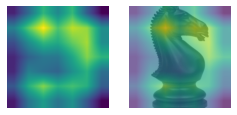

In [7]:
f = os.listdir('/gdrive/My Drive/Chessman-image-dataset/Chess_test/Knight/')
for i in f:
  get_activation_map('/gdrive/My Drive/Chessman-image-dataset/Chess_test/Knight/'+i)

In [8]:
avg_drop

[tensor([0.5347], grad_fn=<DivBackward0>),
 tensor([0.6012], grad_fn=<DivBackward0>),
 tensor([0.3318], grad_fn=<DivBackward0>),
 tensor([0.6931], grad_fn=<DivBackward0>),
 tensor([0.3630], grad_fn=<DivBackward0>),
 tensor([0.4319], grad_fn=<DivBackward0>),
 tensor([0.5967], grad_fn=<DivBackward0>),
 tensor([0.4729], grad_fn=<DivBackward0>),
 tensor([0.6383], grad_fn=<DivBackward0>),
 tensor([0.3155], grad_fn=<DivBackward0>),
 tensor([0.], grad_fn=<MulBackward0>),
 tensor([0.2475], grad_fn=<DivBackward0>),
 tensor([0.0803], grad_fn=<DivBackward0>),
 tensor([0.4893], grad_fn=<DivBackward0>),
 tensor([0.6158], grad_fn=<DivBackward0>),
 tensor([0.3177], grad_fn=<DivBackward0>)]

In [9]:
avg_drop

[tensor([0.5347], grad_fn=<DivBackward0>),
 tensor([0.6012], grad_fn=<DivBackward0>),
 tensor([0.3318], grad_fn=<DivBackward0>),
 tensor([0.6931], grad_fn=<DivBackward0>),
 tensor([0.3630], grad_fn=<DivBackward0>),
 tensor([0.4319], grad_fn=<DivBackward0>),
 tensor([0.5967], grad_fn=<DivBackward0>),
 tensor([0.4729], grad_fn=<DivBackward0>),
 tensor([0.6383], grad_fn=<DivBackward0>),
 tensor([0.3155], grad_fn=<DivBackward0>),
 tensor([0.], grad_fn=<MulBackward0>),
 tensor([0.2475], grad_fn=<DivBackward0>),
 tensor([0.0803], grad_fn=<DivBackward0>),
 tensor([0.4893], grad_fn=<DivBackward0>),
 tensor([0.6158], grad_fn=<DivBackward0>),
 tensor([0.3177], grad_fn=<DivBackward0>)]

In [10]:
sum(avg_drop) / len(avg_drop)

tensor([0.4206], grad_fn=<DivBackward0>)

In [11]:
avg_drop_sc

[tensor([0.5026], grad_fn=<DivBackward0>),
 tensor([0.1196], grad_fn=<DivBackward0>),
 tensor([0.0551], grad_fn=<DivBackward0>),
 tensor([0.6496], grad_fn=<DivBackward0>),
 tensor([0.3243], grad_fn=<DivBackward0>),
 tensor([0.2248], grad_fn=<DivBackward0>),
 tensor([0.2282], grad_fn=<DivBackward0>),
 tensor([0.3556], grad_fn=<DivBackward0>),
 tensor([0.5557], grad_fn=<DivBackward0>),
 tensor([0.1451], grad_fn=<DivBackward0>),
 tensor([0.], grad_fn=<MulBackward0>),
 tensor([0.6020], grad_fn=<DivBackward0>),
 tensor([0.5916], grad_fn=<DivBackward0>),
 tensor([0.0934], grad_fn=<DivBackward0>),
 tensor([0.1988], grad_fn=<DivBackward0>),
 tensor([0.5544], grad_fn=<DivBackward0>)]

In [12]:
sum(avg_drop_sc) / len(avg_drop_sc)

tensor([0.3251], grad_fn=<DivBackward0>)